## Choose example here

In [7]:
# Name of test to be plotted
test = 'Example4'

if test == 'Example1':
    model = 'TwoBreakdownTypes'
    mode = 'VP'
    M = 9 # specific what grid size to use as a an exponent of 2
    name = test + '_' + model + '_' + mode + '_' + str(M)
elif test == 'Example2':
    model = 'OnlyPartialBreakdowns'
    mode = 'VP'
    bdr = 3 # specify which breakdown rate to visualize
    name = test + '_' + model + '_' + mode + '_' + str(bdr)
elif test == 'Example3':
    model = 'OnlyPartialBreakdowns' # Can choose "TwoBreakdownTypes" or "OnlyPartialBreakdowns"
    mode = 'VP'
    name = test + '_' + model + '_' + mode
elif test == 'Example4':
    model = 'OnlyPartialBreakdowns' # Can choose "TwoBreakdownTypes" or "OnlyPartialBreakdowns"
    mode = 'VP'
    name = test + '_' + model + '_' + mode
else:
    print('Invalid test specified.')

# Set to true to save figures
save_to_file = True

## Import Packages

In [8]:
## General purpose
import numpy as np
import os
import numpy.ma as ma
import string
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D


## Plotting-specific
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import matplotlib.ticker as ticker

## Set plotting defaults
titletextsize = 18
labeltextsize = 14
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('savefig', dpi = 300)
n_levels = 11

figwidth  = 12
figheight = 3

## Define function for formatting colorbar in scientific notation
##      From here: https://stackoverflow.com/questions/25983218/scientific-notation-colorbar-in-matplotlib
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

## Define function for formatting colorbar with 3 significant figures
##      Based on code here: https://stackoverflow.com/questions/3410976/how-to-round-a-number-to-significant-figures-in-python
def fmt3(x, pos):
    if len('{:.3g}'.format(x)) < 4:
        if x < 10:
            return r'{:.2f}'.format(float('{:.3g}'.format(x)))
        else:
            return r'{:.1f}'.format(float('{:.3g}'.format(x)))
    else:
        return r'{:g}'.format(float('{:.3g}'.format(x)))


## Define function for setting axis size
##      From here: https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
## Define output directory for saving figures to file
output_directory = name
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

## Read in Arrays

In [9]:
data_location = '../output/' + name
fdtype = np.dtype('f8')

## Read in grid sizes
gridsizes = np.fromfile(data_location + '_GridSizes', 'int32')
nx = gridsizes[0]
ny = gridsizes[1]

## Read in step sizes
stepsizes = np.fromfile(data_location + '_StepSizes', fdtype)
dx = stepsizes[0]
dy = stepsizes[1]

## Define grid
X = np.arange(0,nx)*dx
Y = np.arange(0,ny)*dy

## Read in domain
domain = np.fromfile(data_location + '_Domain',np.dtype('bool'))
domain = domain.reshape(nx,ny)
not_domain = 1-domain

## Read in depots
depots = np.fromfile(data_location + '_Depots',np.dtype('bool'))
depots = depots.reshape(nx,ny)

## Read in goal
goals = np.fromfile(data_location + '_Goal',np.dtype('bool'))
goals = goals.reshape(nx,ny)

X_grid, Y_grid = np.meshgrid(X,Y)
depots_y = X_grid[depots]
depots_x = Y_grid[depots]
goals_y = X_grid[goals]
goals_x = Y_grid[goals]

## Define function for reading variables from file
def read_from_file(suffix):
    temp = np.fromfile(data_location + suffix, fdtype)
    temp = temp.reshape(nx,ny)
    return ma.masked_array(temp, mask=not_domain)

## Read in arrays
K_1   = read_from_file('_WorkingRunningCost')
f_1   = read_from_file('_WorkingSpeed')
u_1   = read_from_file('_WorkingCost')

if model == 'TwoBreakdownTypes' or model == 'OnlyTotalBreakdowns':
    lambda_1 = read_from_file('_WorkingTotalBreakdownRate')
    K_r   = read_from_file('_RepairRunningCost')
    f_r   = read_from_file('_RepairSpeed')
    u_r   = read_from_file('_RepairCost')
    r = read_from_file('_FieldRepairCost')
if model == 'TwoBreakdownTypes' or model == 'OnlyPartialBreakdowns':
    u_2   = read_from_file('_DamagedCost')
    f_2   = read_from_file('_DamagedSpeed')
    K_2   = read_from_file('_DamagedRunningCost')
    phi = read_from_file('_WorkingPartialBreakdownRate')
    
    ## Read in summary data
    iterTypes = np.fromfile(data_location + '_IterationType', np.dtype('int'))
    iterProgress = np.fromfile(data_location + '_IterationProgress', fdtype)
if model == 'TwoBreakdownTypes':
    lambda_2 = read_from_file('_DamagedTotalBreakdownRate')

# Plotting

### Breakdown Rate function $\phi(x,y)$

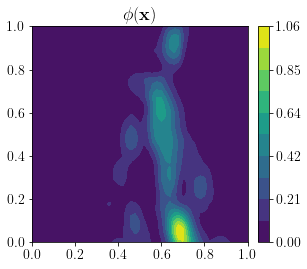

In [10]:
%matplotlib inline

if model == 'TwoBreakdownTypes':
    bdr_list = [phi, lambda_1, lambda_2]
    titles = ['$\phi(\mathbf{x})$', '$\lambda_{1}(\mathbf{x})$', '$\lambda_{2}(\mathbf{x})$']
    files = ['Partial', 'WorkingTotal', 'DamagedTotal']
    
    bdr_min = 0.5
    bdr_max = 0.01
    for i in range(3):
        bdr_min_current = np.min(bdr_list[i])
        bdr_max_current = np.max(bdr_list[i])
        
        if bdr_min_current < bdr_min:
            bdr_min = bdr_min_current
        if bdr_max_current > bdr_max:
            bdr_max = bdr_max_current
    
    for i in range(3):
        bdr = bdr_list[i]
        title = titles[i]
        fig, ax = plt.subplots(1,1)
        
        ## Contour plot
        bdr_levels = np.linspace(bdr_min, bdr_max, n_levels);
        im = ax.contourf(X, Y, np.transpose(bdr), bdr_levels)
        ax.tick_params(labelsize = labeltextsize)
        ax.set_title(title, fontsize=titletextsize)

        ## Add colorbar and fix aspect ratio
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')
        cax.tick_params(labelsize=labeltextsize)
        cb = fig.colorbar(im, cax, format=ticker.FormatStrFormatter('%.2f')) # Force two decimal places for colorbar
        ax.set_aspect(1)
        set_size((1/3)*figwidth, figheight)
        
        if save_to_file:
            fig.savefig(output_directory + '/' + name + '_' + files[i] + 'BreakdownRate.png', bbox_inches='tight')
elif model == 'OnlyPartialBreakdowns':
    fig, ax = plt.subplots(1,1)
    title = '$\phi(\mathbf{x})$'

    ## Contour plot
    phi_min = min(np.min(phi),0)
    phi_max = max(np.max(phi),1)
    phi_levels = np.linspace(phi_min, phi_max, n_levels);
    im = ax.contourf(X, Y, np.transpose(phi), phi_levels)
    ax.tick_params(labelsize = labeltextsize)
    ax.set_title(title, fontsize=titletextsize)

    ## Add colorbar and fix aspect ratio
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')
    cax.tick_params(labelsize=labeltextsize)
    cb = fig.colorbar(im, cax, format=ticker.FormatStrFormatter('%.2f')) # Force two decimal places for colorbar
    ax.set_aspect(1)
    set_size((1/3)*figwidth, figheight)

    
    if save_to_file:
        fig.savefig(output_directory + '/' + name + '_PartialBreakdownRate.png', bbox_inches='tight')
elif model == 'OnlyTotalBreakdowns':
    fig, ax = plt.subplots(1,1)
    title = '$\lambda_{1}(\mathbf{x})$'

    ## Contour plot
    lambda_1_min = min(np.min(lambda_1),0)
    lambda_1_max = max(np.max(lambda_1),1)
    lambda_1_levels = np.linspace(lambda_1_min, lambda_1_max, n_levels);
    im = ax.contourf(X, Y, np.transpose(lambda_1), lambda_1_levels)
    ax.tick_params(labelsize = labeltextsize)
    ax.set_title(title, fontsize=titletextsize)

    ## Add colorbar and fix aspect ratio
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')
    cax.tick_params(labelsize=labeltextsize)
    cb = fig.colorbar(im, cax, format=ticker.FormatStrFormatter('%.2f')) # Force two decimal places for colorbar
    ax.set_aspect(1)
    set_size((1/3)*figwidth, figheight)


    if save_to_file:
        fig.savefig(output_directory + '/' + name + '_TotalBreakdownRate.png', bbox_inches='tight')


### Running Cost $K(x,y)$

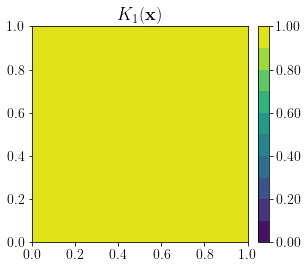

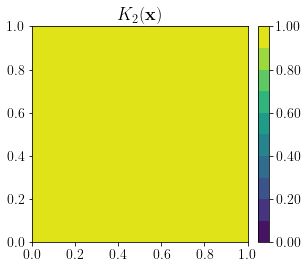

In [11]:
%matplotlib inline

if model == 'TwoBreakdownTypes':
    K_list = [np.round(K_1 - (lambda_1)*(r+u_r), 5), np.round(K_2 - (lambda_2)*(r+u_r), 5), K_r]
    titles = ['$K_1(\mathbf{x})$', '$K_2(\mathbf{x})$', '$K_R(\mathbf{x})$']
    files = ['Working', 'Damaged', 'Repair']
    
    K_min = 0
    K_max = 1
    for i in range(len(K_list)):
        K_min_current = np.min(K_list[i])
        K_max_current = np.max(K_list[i])
        
        if K_min_current < K_min:
            K_min = K_min_current
        if K_max_current > K_max:
            K_max = K_max_current
    
    for i in range(len(K_list)):
        fig, ax = plt.subplots(1,1)
        K = K_list[i]
        
        ## Contour plot
        K_levels = np.linspace(K_min, K_max, n_levels);
        im = ax.contourf(X, Y, np.transpose(K), K_levels)
        ax.tick_params(labelsize = labeltextsize)
        ax.set_title(titles[i], fontsize=titletextsize)

        ## Add colorbar and fix aspect ratio
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')
        cax.tick_params(labelsize=labeltextsize)
        cb = fig.colorbar(im, cax, format=ticker.FormatStrFormatter('%.2f')) # Force two decimal places for colorbar
        ax.set_aspect(1)
        set_size((1/3)*figwidth, figheight)
        
        if save_to_file:
            fig.savefig(output_directory + '/' + name + '_' + files[i] + 'RunningCost.png', bbox_inches='tight')
elif model == 'OnlyPartialBreakdowns':
    K_list = [K_1, K_2]
    titles = ['$K_1(\mathbf{x})$', '$K_2(\mathbf{x})$']
    files = ['Working', 'Damaged']

    K_min = 0
    K_max = 1
    for i in range(len(K_list)):
        K_min_current = np.min(K_list[i])
        K_max_current = np.max(K_list[i])
        
        if K_min_current < K_min:
            K_min = K_min_current
        if K_max_current > K_max:
            K_max = K_max_current
    
    for i in range(len(K_list)):
        fig, ax = plt.subplots(1,1)
        K = K_list[i]

        ## Contour plot
        K_max = max(np.max(K), 1)
        K_min = min(np.min(K), K_max-1)
        K_levels = np.linspace(K_min, K_max, n_levels);
        im = ax.contourf(X, Y, np.transpose(K), K_levels)
        ax.tick_params(labelsize = labeltextsize)
        ax.set_title(titles[i], fontsize=titletextsize)

        ## Add colorbar and fix aspect ratio
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')
        cax.tick_params(labelsize=labeltextsize)
        cb = fig.colorbar(im, cax, format=ticker.FormatStrFormatter('%.2f')) # Force two decimal places for colorbar
        ax.set_aspect(1)
        set_size((2/3)*figwidth, figheight)
        
        if save_to_file:
            fig.savefig(output_directory + '/' + name + '_' + files[i] + 'RunningCost.png', bbox_inches='tight')
            
elif model == 'OnlyTotalBreakdowns':
    K_list = [np.round(K_1 - (lambda_1/f_1)*(r+u_r), 5), K_r]
    titles = ['$K_1(\mathbf{x})$', '$K_R(\mathbf{x})$']
    files = ['Working', 'Repair']

    K_min = 0
    K_max = 1
    for i in range(len(K_list)):
        K_min_current = np.min(K_list[i])
        K_max_current = np.max(K_list[i])
        
        if K_min_current < K_min:
            K_min = K_min_current
        if K_max_current > K_max:
            K_max = K_max_current
    
    for i in range(len(K_list)):
        fig, ax = plt.subplots(1,1)
        K = K_list[i]

        ## Contour plot
        K_max = max(np.max(K), 1)
        K_min = min(np.min(K), K_max-1)
        K_levels = np.linspace(K_min, K_max, n_levels);
        im = ax.contourf(X, Y, np.transpose(K), K_levels)
        ax.tick_params(labelsize = labeltextsize)
        ax.set_title(titles[i], fontsize=titletextsize)

        ## Add colorbar and fix aspect ratio
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')
        cax.tick_params(labelsize=labeltextsize)
        cb = fig.colorbar(im, cax, format=ticker.FormatStrFormatter('%.2f')) # Force two decimal places for colorbar
        ax.set_aspect(1)
        set_size((2/3)*figwidth, figheight)
        
        if save_to_file:
            fig.savefig(output_directory + '/' + name + '_' + files[i] + 'RunningCost.png', bbox_inches='tight')
    
plt.show()

### Speed f(x,y)

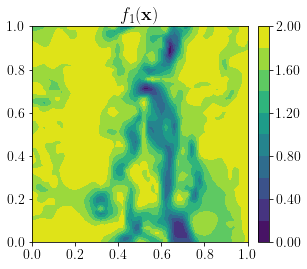

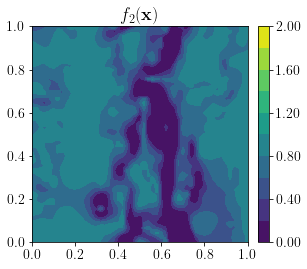

In [12]:
%matplotlib inline


if model == 'TwoBreakdownTypes':
    f_list = [f_1, f_2, f_r]
    titles = ['$f_1(\mathbf{x})$', '$f_2(\mathbf{x})$', '$f_R(\mathbf{x})$']
    files = ['Working', 'Damaged', 'Repair']
    
    f_min = 1
    f_max = 0
    for i in range(len(f_list)):
        f_min_current = np.min(f_list[i])
        f_max_current = np.max(f_list[i])
        
        if f_min_current < f_min:
            f_min = f_min_current
        if f_max_current > f_max:
            f_max = f_max_current
    
    for i in range(len(f_list)):
        fig, ax = plt.subplots(1,1)
        f = f_list[i]
        title = titles[i]

        ## Contour plot
        f_max = max(np.max(f), 1)
        f_min = min(np.min(f), 0)
        f_levels = np.linspace(f_min, f_max, n_levels);
        im = ax.contourf(X, Y, np.transpose(f), f_levels)
        ax.tick_params(labelsize = labeltextsize)
        ax.set_title(title, fontsize=titletextsize)

        ## Add colorbar and fix aspect ratio
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')
        cax.tick_params(labelsize=labeltextsize)
        cb = fig.colorbar(im, cax, format=ticker.FormatStrFormatter('%.2f')) # Force two decimal places for colorbar
        ax.set_aspect(1)
        set_size((1/3)*figwidth, figheight)
        
        if save_to_file:
            fig.savefig(output_directory + '/' + name + '_' + files[i] + 'Speed.png', bbox_inches='tight')
            
elif model == 'OnlyPartialBreakdowns':
    f_list = [f_1, f_2]
    titles = ['$f_1(\mathbf{x})$', '$f_2(\mathbf{x})$']
    files = ['Working', 'Broken']
    
    f_min = 0
    f_max = 1
    for i in range(len(f_list)):
        f_min_current = np.min(f_list[i])
        f_max_current = np.max(f_list[i])
        
        if f_min_current < f_min:
            f_min = f_min_current
        if f_max_current > f_max:
            f_max = f_max_current
    
    for i in range(len(f_list)):
        fig, ax = plt.subplots(1,1)
        f = f_list[i]
        title = titles[i]

        ## Contour plot
        f_levels = np.linspace(f_min, f_max, n_levels);
        im = ax.contourf(X, Y, np.transpose(f), f_levels)
        ax.tick_params(labelsize = labeltextsize)
        ax.set_title(title, fontsize=titletextsize)

        ## Add colorbar and fix aspect ratio
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')
        cax.tick_params(labelsize=labeltextsize)
        cb = fig.colorbar(im, cax, format=ticker.FormatStrFormatter('%.2f')) # Force two decimal places for colorbar
        ax.set_aspect(1)
        set_size((1/3)*figwidth, figheight)
        
        if save_to_file:
            fig.savefig(output_directory + '/' + name + '_' + files[i] + 'Speed.png', bbox_inches='tight')
elif model == 'OnlyTotalBreakdowns':
    f_list = [f_1, f_r]
    titles = ['$f_1(\mathbf{x})$', '$f_R(\mathbf{x})$']
    
    f_min = 0
    f_max = 1
    for i in range(len(f_list)):
        f_min_current = np.min(f_list[i])
        f_max_current = np.max(f_list[i])
        
        if f_min_current < f_min:
            f_min = f_min_current
        if f_max_current > f_max:
            f_max = f_max_current
    
    for i in range(len(f_list)):
        fig, ax = plt.subplots(1,1)
        f = f_list[i]
        title = titles[i]

        ## Contour plot
        f_levels = np.linspace(f_min, f_max, n_levels);
        im = ax.contourf(X, Y, np.transpose(f), f_levels)
        ax.tick_params(labelsize = labeltextsize)
        ax.set_title(title, fontsize=titletextsize)

        ## Add colorbar and fix aspect ratio
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')
        cax.tick_params(labelsize=labeltextsize)
        cb = fig.colorbar(im, cax, format=ticker.FormatStrFormatter('%.2f')) # Force two decimal places for colorbar
        ax.set_aspect(1)
        set_size((1/3)*figwidth, figheight)

plt.show()
    

### Repair Vehicle Cost $u_3(x,y)$

In [13]:
%matplotlib inline

if model == 'TwoBreakdownTypes' or model == 'OnlyTotalBreakdowns':
    fig, ax = plt.subplots()

    ## Contour plot
    u_r_min = np.min(u_r)
    if u_r_min < 0.001:
        u_r_min = 0
    u_r_max = np.max(u_r)

    u_r_levels = np.linspace(u_r_min, u_r_max, n_levels);
    im = ax.contourf(X, Y, np.transpose(u_r), u_r_levels)
    plt.plot(depots_x, depots_y, markersize = 0.8*titletextsize, linestyle='None', markerfacecolor = "tab:red", marker = "p", markeredgecolor = 'none')
    plt.plot(goals_x, goals_y, markersize = 0.9*titletextsize, markerfacecolor = "yellow", marker = "*", markeredgecolor = 'none')
    plt.scatter(goals_x, goals_y, s = 7*titletextsize, c="yellow", marker = "*")
    ax.tick_params(labelsize = labeltextsize)
    ax.set_title('$u_R(\mathbf{x})$', fontsize=titletextsize)
    plt.xlim([0,1])
    plt.ylim([0,1])

    ## Add colorbar and fix aspect ratio
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')
    cax.tick_params(labelsize = labeltextsize)
    if u_r_max >= 100: 
        cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt)) # Force scientific notation for colorbar
    else:
        cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt3)) # No scientific notation for colorbar
    ax.set_aspect(1)
    set_size(figwidth, figheight)


    plt.show()
    if save_to_file:
        fig.savefig(output_directory + '/' + name + '_RepairCost.png', bbox_inches='tight')

### Broken Cost $u_2(x,y)$

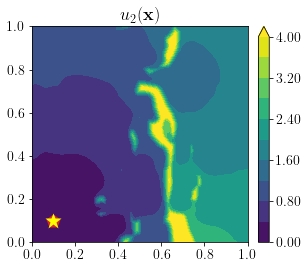

In [18]:
%matplotlib inline
if model == 'TwoBreakdownTypes' or model == 'OnlyPartialBreakdowns':
    fig, ax = plt.subplots()

    u_2_min = np.min(u_2)
    if u_2_min < 0.001:
        u_2_min = 0
    if test == 'Example4':
        u_2_max = 4
    else:
        u_2_max = np.max(u_2)
    u_2_levels = np.linspace(u_2_min, u_2_max, n_levels);
    
    if test == 'Example4':
        im = ax.contourf(X, Y, np.transpose(u_2), u_2_levels, extend = 'max')
    else:
        im = ax.contourf(X, Y, np.transpose(u_2), u_2_levels)
        
    ## Contour Plot
    plt.plot(depots_x, depots_y, markersize = 0.8*titletextsize, linestyle = 'None', markerfacecolor = "tab:red", marker = "p", markeredgecolor = 'none')
    plt.plot(goals_x, goals_y, markersize = 0.9*titletextsize, markerfacecolor = "yellow", marker = "*", markeredgecolor = 'none')
    ax.tick_params(labelsize = labeltextsize)
    if test == 'Example3':
        if model == 'TwoBreakdownTypes':
            ax.set_title('$u_2(\mathbf{x})\,$   $\,(\lambda_1 = 1, \lambda_2 = 3$)', fontsize=titletextsize)
        else:
            ax.set_title('$u_2(\mathbf{x})\,$   $\,(\lambda_1 = \lambda_2 = 0$)', fontsize=titletextsize)
    else:
        ax.set_title('$u_2(\mathbf{x})$', fontsize=titletextsize)    
    plt.xlim([0,1])
    plt.ylim([0,1])

    ## Add colorbar and fix aspect ratio
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')
    cax.tick_params(labelsize = labeltextsize)
    if u_2_max >= 100:
        cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt)) # Force scientific notation for colorbar
    else:
        cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt3)) # No scientific notation for colorbar
    ax.set_aspect(1)
    set_size(figwidth, figheight)


    plt.show()
    if save_to_file:
        fig.savefig(output_directory + '/' + name + '_DamagedCost.png', bbox_inches='tight')

### Working Cost $u_1(x,y)$

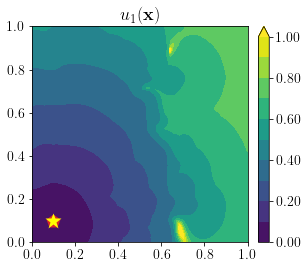

In [19]:
%matplotlib inline
fig, ax = plt.subplots()


## Set levels for colorbar
u_1_min = np.min(u_1)
if u_1_min < 0.001:
        u_1_min = 0
# u_1_min = 45
if test == 'Example4':
    u_1_max = 1
else:
    u_1_max = np.max(u_1)

u_1_levels = np.linspace(u_1_min,u_1_max,n_levels)

## Contour plot of expected Profit P
if test == 'Example4':
    im = ax.contourf(X, Y, np.transpose(u_1), u_1_levels, extend = 'max')
else:
    im = ax.contourf(X, Y, np.transpose(u_1), u_1_levels)# plt.plot(depots_x, depots_y, markersize = 0.8*titletextsize, markerfacecolor = "tab:red", marker = "p", markeredgecolor = 'k')
# plt.plot(goals_x, goals_y, markersize = 0.9*titletextsize, markerfacecolor = "yellow", marker = "*", markeredgecolor = 'k')
plt.plot(depots_x, depots_y, markersize = 0.8*titletextsize, linestyle = 'None', markerfacecolor = "tab:red", marker = "p", markeredgecolor = 'none')
plt.plot(goals_x, goals_y, markersize = 0.9*titletextsize, markerfacecolor = "yellow", marker = "*", markeredgecolor = 'none')
ax.tick_params(labelsize = labeltextsize)
if test == 'Example3':
    if model == 'TwoBreakdownTypes':
        ax.set_title('$u_1(\mathbf{x})\,$   $\,(\lambda_1 = 1, \lambda_2 = 3$)', fontsize=titletextsize)
    else:
        ax.set_title('$u_1(\mathbf{x})\,$   $\,(\lambda_1 = \lambda_2 = 0$)', fontsize=titletextsize)
else:
    ax.set_title('$u_1(\mathbf{x})$', fontsize=titletextsize)
plt.xlim([0,1])
plt.ylim([0,1])

## Add colorbar and fix aspect ratio
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cax.tick_params(labelsize=labeltextsize)
if u_1_max >= 100:
    cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt)) # Force scientific notation for colorbar
else:
    cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt3)) # No scientific notation for colorbar
ax.set_aspect(1)
set_size(figwidth, figheight)

plt.show()
if save_to_file:
    fig.savefig(output_directory + '/' + name + '_WorkingCost.png', bbox_inches='tight')


## Iteration Progress

C:\Users\mag433\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
C:\Users\mag433\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
C:\Users\mag433\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.


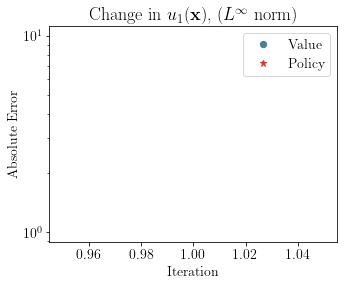

In [20]:
if model == 'TwoBreakdownTypes' or model == 'OnlyPartialBreakdowns':
    if mode == 'V':
        iterTypes = iterTypes[1:]
        iterProgress = iterProgress[1:]
    
    # Graph iteration types and progress    
    N = len(iterTypes)
    ind = np.array(range(1,N+1))

    valInd = ind[iterTypes==0]
    valData = iterProgress[iterTypes==0]
    polInd = ind[iterTypes==1]
    polData = iterProgress[iterTypes==1]
    plt.plot(valInd, valData, marker='o', markerfacecolor='#468197', markeredgecolor='#468197', markersize = 0.35*titletextsize, linestyle='None')
    plt.plot(polInd, polData, marker='*', markerfacecolor='#E83025', markeredgecolor='#E83025', markersize = 0.35*titletextsize, linestyle='None')

    fig = plt.gcf()
    ax = plt.gca()

    ax.set_yscale('log')
    plt.ylim(np.min(iterProgress)/2, np.max(iterProgress)*2)
    ax.tick_params(labelsize = labeltextsize, axis = 'both')
    ax.set_title('Change in $u_1(\mathbf{x})$, ($L^\infty$ norm)', fontsize=titletextsize)
    
    if mode == 'VP':
        plt.legend(['Value', 'Policy'], fontsize = labeltextsize)
    else: 
        plt.legend(['Value'], fontsize = labeltextsize)
    set_size((1/3)*figwidth, figheight)
    plt.xlabel('Iteration', fontsize=labeltextsize)
    plt.ylabel('Absolute Error', fontsize=labeltextsize)

    plt.show()
    if save_to_file:
        fig.savefig(output_directory + '/' + name + '_IterationProgress.png', bbox_inches='tight')